# Dataiku Technical Assessment - US Census Income Modelling

The following sample US Census dataset contains detailed but anonymized information for approximately 300,000 people:

http://thomasdata.s3.amazonaws.com/ds/us_census_full.zip

The goal of this exercise is to model the binary information contained in the last column (42nd), i.e., which people make more or less than $50,000 / year, from the information contained in the other columns. 

## Import Libraries

In [1]:
%matplotlib inline

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import VarianceThreshold
#from sklearn.model_selection import StratifiedKFold
#from sklearn.feature_selection import RFECV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
#from sklearn.svm import SVC
#from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

pd.options.display.max_columns = 50

import warnings
warnings.filterwarnings(action='ignore')

## Load Train and Test Data

From initial inspection of the data there are no column headers, spaces preceding data fields and na values are mostly represented by 'Not in universe'. Account for this upon loading.

In [2]:
us_census_train = pd.read_csv('us_census_full/census_income_learn.csv', 
                              header = None, skipinitialspace = True, na_values= 'Not in universe')
us_census_test = pd.read_csv('us_census_full/census_income_test.csv', 
                              header = None, skipinitialspace = True, na_values= 'Not in universe')

First need column headers which can be found in accompanying metadata. Print metadata with row numbers for inspection.

In [3]:
with open('us_census_full/census_income_metadata.txt', 'r') as f:
    for lineNo, line in enumerate(f.readlines()):
        print(lineNo, line)

0 | This data was extracted from the census bureau database found at

1 | http://www.census.gov/ftp/pub/DES/www/welcome.html

2 | Donor: Terran Lane and Ronny Kohavi

3 |        Data Mining and Visualization

4 |        Silicon Graphics.

5 |        e-mail: terran@ecn.purdue.edu, ronnyk@sgi.com for questions.

6 |

7 | The data was split into train/test in approximately 2/3, 1/3

8 | proportions using MineSet's MIndUtil mineset-to-mlc.

9 |

10 | Prediction task is to determine the income level for the person

11 | represented by the record.  Incomes have been binned at the $50K

12 | level to present a binary classification problem, much like the

13 | original UCI/ADULT database.  The goal field of this data, however,

14 | was drawn from the "total person income" field rather than the

15 | "adjusted gross income" and may, therefore, behave differently than the

16 | orginal ADULT goal field.

17 |

18 | More information detailing the meaning of the attributes can be

19 | found in 

Column names not consistent in metadata. Most accurate likely to be those from line 141 onwards with lists of possible values for each column. Extract these column names as list.

In [4]:
columns = []
with open('us_census_full/census_income_metadata.txt', 'r') as f:
    for lineNo, line in enumerate(f.readlines()):
        if lineNo > 141:
            featureName = line.split(':')[0]
            featureName = featureName.replace(' ', '_')
            columns.append(featureName)
    print(columns)

['age', 'class_of_worker', 'detailed_industry_recode', 'detailed_occupation_recode', 'education', 'wage_per_hour', 'enroll_in_edu_inst_last_wk', 'marital_stat', 'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin', 'sex', 'member_of_a_labor_union', 'reason_for_unemployment', 'full_or_part_time_employment_stat', 'capital_gains', 'capital_losses', 'dividends_from_stocks', 'tax_filer_stat', 'region_of_previous_residence', 'state_of_previous_residence', 'detailed_household_and_family_stat', 'detailed_household_summary_in_household', '|_instance_weight', 'instance_weight', 'migration_code-change_in_msa', 'migration_code-change_in_reg', 'migration_code-move_within_reg', 'live_in_this_house_1_year_ago', 'migration_prev_res_in_sunbelt', 'num_persons_worked_for_employer', 'family_members_under_18', 'country_of_birth_father', 'country_of_birth_mother', 'country_of_birth_self', 'citizenship', 'own_business_or_self_employed', "fill_inc_questionnaire_for_veteran's_admin", 'vete

Notice instance_weight is repeated as we are reminded to ignore this column for modelling (as sample distribution shouldn't affect predictions). Remove this repeated column name and add header for incomeBracket.

In [5]:
columns.remove('|_instance_weight')
columns.append('incomeBracket')

Check that the length of these column names matches the number of columns in the training and test data and add headers to the dataframes.

In [6]:
try:
    assert(len(columns) == len(us_census_train.columns) == len(us_census_test.columns))
    us_census_train.columns = columns
    us_census_test.columns = columns
except:
    print('Number of column names does not match number of columns in either training or test DataFrames')

In [7]:
us_census_train.head(50)

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_a_labor_union,reason_for_unemployment,full_or_part_time_employment_stat,capital_gains,capital_losses,dividends_from_stocks,tax_filer_stat,region_of_previous_residence,state_of_previous_residence,detailed_household_and_family_stat,detailed_household_summary_in_household,instance_weight,migration_code-change_in_msa,migration_code-change_in_reg,migration_code-move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,num_persons_worked_for_employer,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,incomeBracket
0,73,NaN,0,0,High school graduate,0,NaN,Widowed,Not in universe or children,NaN,White,All other,Female,NaN,NaN,Not in labor force,0,0,0,Nonfiler,NaN,NaN,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,NaN,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,NaN,Divorced,Construction,Precision production craft & repair,White,All other,Male,NaN,NaN,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,NaN,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,52,94,- 50000.
2,18,NaN,0,0,10th grade,0,High school,Never married,Not in universe or children,NaN,Asian or Pacific Islander,All other,Female,NaN,NaN,Not in labor force,0,0,0,Nonfiler,NaN,NaN,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,NaN,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,NaN,2,0,95,- 50000.
3,9,NaN,0,0,Children,0,NaN,Never married,Not in universe or children,NaN,White,All other,Female,NaN,NaN,Children or Armed Forces,0,0,0,Nonfiler,NaN,NaN,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,NaN,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,NaN,0,0,94,- 50000.
4,10,NaN,0,0,Children,0,NaN,Never married,Not in universe or children,NaN,White,All other,Female,NaN,NaN,Children or Armed Forces,0,0,0,Nonfiler,NaN,NaN,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,NaN,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,NaN,0,0,94,- 50000.
5,48,Private,40,10,Some college but no degree,1200,NaN,Married-civilian spouse present,Entertainment,Professional specialty,Amer Indian Aleut or Eskimo,All other,Female,No,NaN,Full-time schedules,0,0,0,Joint both under 65,NaN,NaN,Spouse of householder,Spouse of householder,162.61,?,?,?,Not in universe under 1 year old,?,1,NaN,Philippines,United-States,United-States,Native- Born in the United States,2,NaN,2,52,95,- 50000.
6,42,Private,34,3,Bachelors degree(BA AB BS),0,NaN,Married-civilian spouse present,Finance insurance and real estate,Executive admin and managerial,White,All other,Male,NaN,NaN,Children or Armed Forces,5178,0,0,Joint both under 65,NaN,NaN,Householder,Householder,1535.86,Nonmover,Nonmover,Nonmover,Yes,NaN,6,NaN,United-States,United-States,United-States,Native- Born in the United States,0,NaN,2,52,94,- 50000.
7,28,Private,4,40,High school graduate,0,NaN,Never married,Construction,Handlers equip cleaners etc,White,All other,Female,NaN,Job loser - on layoff,Unemployed full-time,0,0,0,Single,NaN,NaN,Secondary individual,Nonrelative of householder,898.83,?,?,?,Not in universe under 1 year old,?,4,NaN,United-States,United-States,United-

Data still needs some cleaning, but column headers seem appropriate for the data so can assume they have been correctly matched.

## Data Cleaning

First remove other na values represented by '?'.

In [8]:
us_census_train = us_census_train.replace('\?', np.nan, regex=True)
us_census_test = us_census_test.replace('\?', np.nan, regex=True)

Now convert all 'object' columns to categorical, and manually convert categorical columns represented by ints.

In [9]:
us_census_train[us_census_train.select_dtypes(['object']).columns] = us_census_train.select_dtypes(['object']).apply(lambda x: x.astype('category'))
us_census_train[['detailed_industry_recode','detailed_occupation_recode','own_business_or_self_employed','veterans_benefits','year']] = us_census_train[['detailed_industry_recode','detailed_occupation_recode','own_business_or_self_employed','veterans_benefits','year']].astype('category')

us_census_test[us_census_test.select_dtypes(['object']).columns] = us_census_test.select_dtypes(['object']).apply(lambda x: x.astype('category'))
us_census_test[['detailed_industry_recode','detailed_occupation_recode','own_business_or_self_employed','veterans_benefits','year']] = us_census_test[['detailed_industry_recode','detailed_occupation_recode','own_business_or_self_employed','veterans_benefits','year']].astype('category')

Drop instance_weight column as we do not want to include this column for modelling (since sample distribution shouldn't affect predictions).

In [10]:
us_census_train.drop('instance_weight', axis=1, inplace=True)
us_census_test.drop('instance_weight', axis=1, inplace=True)

Convert incomeBracket to binary integer variable binaryIncome for ease of plotting.

In [11]:
us_census_train['binaryIncome'] = (us_census_train['incomeBracket'] == '50000+.').astype(int)
us_census_train.drop('incomeBracket', axis=1, inplace=True)

us_census_test['binaryIncome'] = (us_census_test['incomeBracket'] == '50000+.').astype(int)
us_census_test.drop('incomeBracket', axis=1, inplace=True)

Now get some summary statistics on data.

In [12]:
us_census_train.describe(include='all')

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_a_labor_union,reason_for_unemployment,full_or_part_time_employment_stat,capital_gains,capital_losses,dividends_from_stocks,tax_filer_stat,region_of_previous_residence,state_of_previous_residence,detailed_household_and_family_stat,detailed_household_summary_in_household,migration_code-change_in_msa,migration_code-change_in_reg,migration_code-move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,num_persons_worked_for_employer,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,binaryIncome
count,199523.000000,99278,199523.0,199523.0,199523,199523.000000,12580,199523,199523,98839,199523,198649,199523,19064,6070,199523,199523.00000,199523.000000,199523.000000,199523,15773,15065,199523,199523,98311,98311,98311,199523,15773,199523.000000,55291,192810,193404,196130,199523,199523.0,1984,199523.0,199523.000000,199523.0,199523.000000
unique,NaN,8,52.0,47.0,17,NaN,2,7,24,14,5,9,2,2,5,8,NaN,NaN,NaN,6,5,49,38,8,8,7,8,3,2,NaN,4,42,42,42,5,3.0,2,3.0,NaN,2.0,NaN
top,NaN,Private,0.0,0.0,High school graduate,NaN,High school,Never married,Not in universe or children,Adm support including clerical,White,All other,Female,No,Other job loser,Children or Armed Forces,NaN,NaN,NaN,Nonfiler,South,California,Householder,Householder,Nonmover,Nonmover,Nonmover,Not in universe under 1 year old,No,NaN,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0.0,No,2.0,NaN,94.0,NaN
freq,NaN,72028,100684.0,100684.0,48407,NaN,6892,86485,100684,14837,167365,171907,103984,16034,2038,123769,NaN,NaN,NaN,75094,4889,1714,53248,75475,82538,82538,82538,101212,9987,NaN,38983,159163,160479,176989,176992,180672.0,1593,150130.0,NaN,99827.0,NaN
mean,34.494199,NaN,NaN,NaN,NaN,55.426908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,434.71899,37.313788,197.529533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.956180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.174897,NaN,0.062058
std,22.310895,NaN,NaN,NaN,NaN,274.896454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4697.53128,271.896428,1984.163658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.365126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.411488,NaN,0.241261
min,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000
25%,15.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000
50%,33.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,0.000000
75%,50.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.000000,NaN,0.000000


Note max number of persons working for employer is 6, so this data could be categorical rather continuous (as described in metadata), but leave as int for now.

In [13]:
us_census_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 41 columns):
age                                           199523 non-null int64
class_of_worker                               99278 non-null category
detailed_industry_recode                      199523 non-null category
detailed_occupation_recode                    199523 non-null category
education                                     199523 non-null category
wage_per_hour                                 199523 non-null int64
enroll_in_edu_inst_last_wk                    12580 non-null category
marital_stat                                  199523 non-null category
major_industry_code                           199523 non-null category
major_occupation_code                         98839 non-null category
race                                          199523 non-null category
hispanic_origin                               198649 non-null category
sex                                           

View these numbers as percentage nulls.

In [14]:
for col in us_census_train.columns:
    nullPercent = (us_census_train[col].isna().sum()/len(us_census_train[col]))*100
    print('{} : {:.2f}% null'.format(col, nullPercent))

age : 0.00% null
class_of_worker : 50.24% null
detailed_industry_recode : 0.00% null
detailed_occupation_recode : 0.00% null
education : 0.00% null
wage_per_hour : 0.00% null
enroll_in_edu_inst_last_wk : 93.69% null
marital_stat : 0.00% null
major_industry_code : 0.00% null
major_occupation_code : 50.46% null
race : 0.00% null
hispanic_origin : 0.44% null
sex : 0.00% null
member_of_a_labor_union : 90.45% null
reason_for_unemployment : 96.96% null
full_or_part_time_employment_stat : 0.00% null
capital_gains : 0.00% null
capital_losses : 0.00% null
dividends_from_stocks : 0.00% null
tax_filer_stat : 0.00% null
region_of_previous_residence : 92.09% null
state_of_previous_residence : 92.45% null
detailed_household_and_family_stat : 0.00% null
detailed_household_summary_in_household : 0.00% null
migration_code-change_in_msa : 50.73% null
migration_code-change_in_reg : 50.73% null
migration_code-move_within_reg : 50.73% null
live_in_this_house_1_year_ago : 0.00% null
migration_prev_res_in_su

Very high proportion of nulls in some columns. Could drop some of these columns but may lose informative information in model as a non-null value may be a strong predictor (providing we still have sufficient statistics). Therefore include all columns for now and use feature reduction procedures later to select columns.

## Data Visualisation

Now visualise data. Begin with categorical data. 

Left hand column represents counts of entries in each category (ignoring nulls). 

Right hand column represents percentage of people in category that earn over $50,000 / year (predicted outcome of 1) to give us an understanding of initial correlations in the data.

For example, we see that while the vast majority of workers are employed privately, those which are self-employed-incorporated have the highest probability (nearly 35\%) of earning above $50,000 / year.

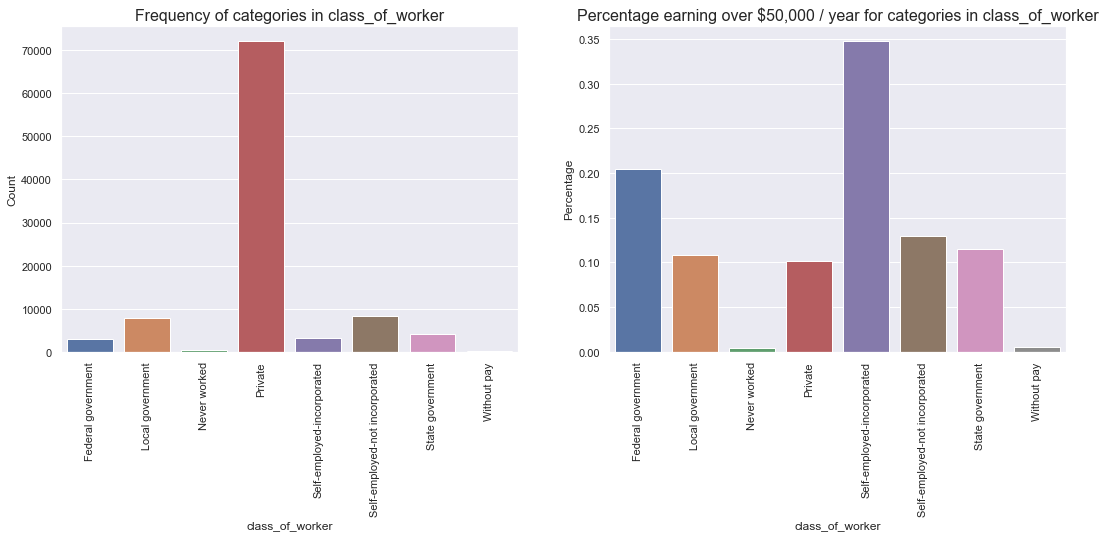

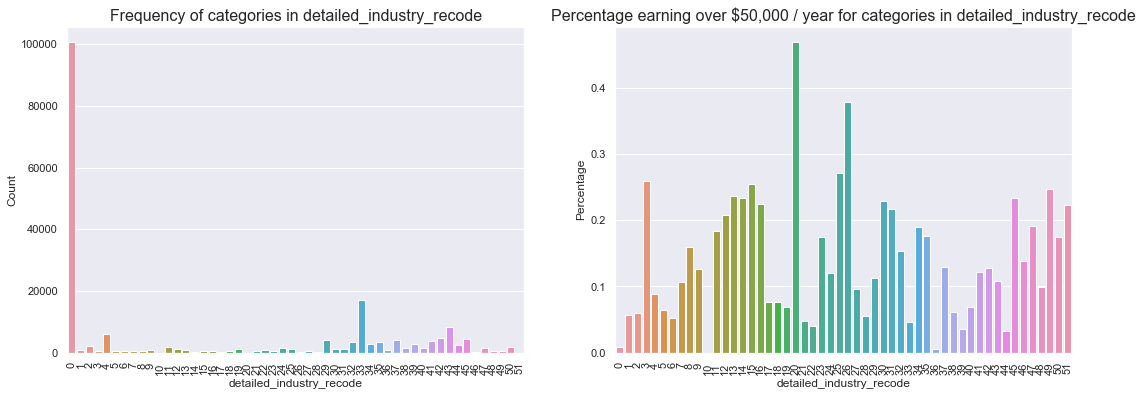

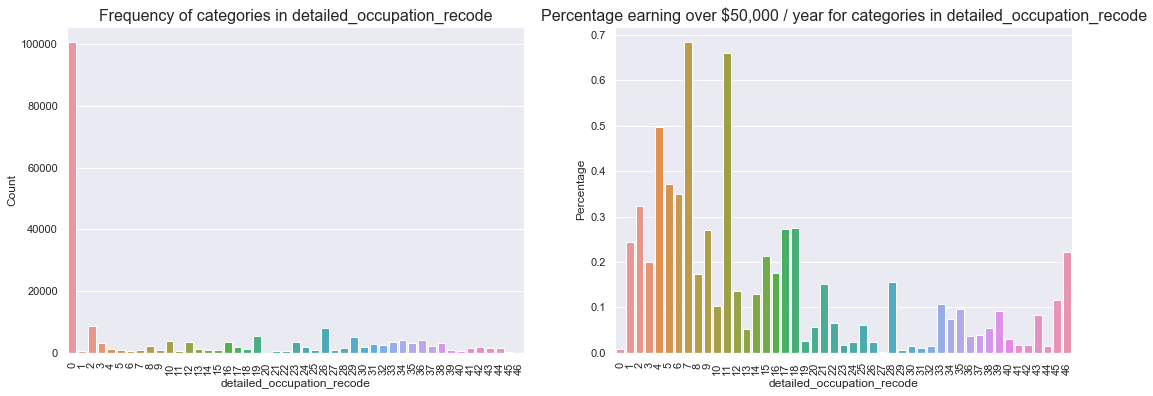

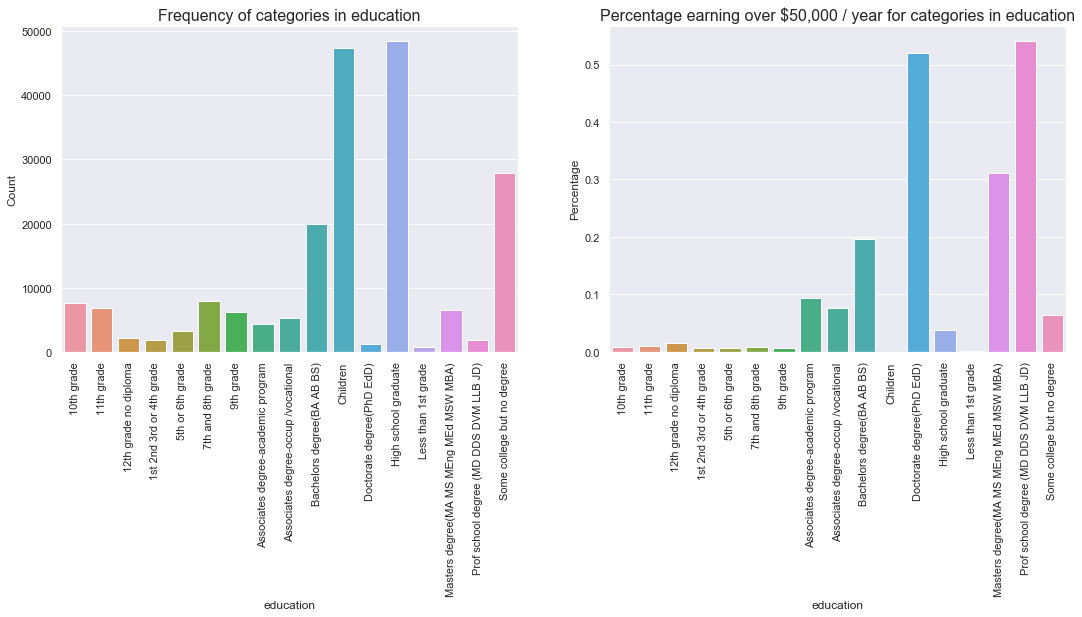

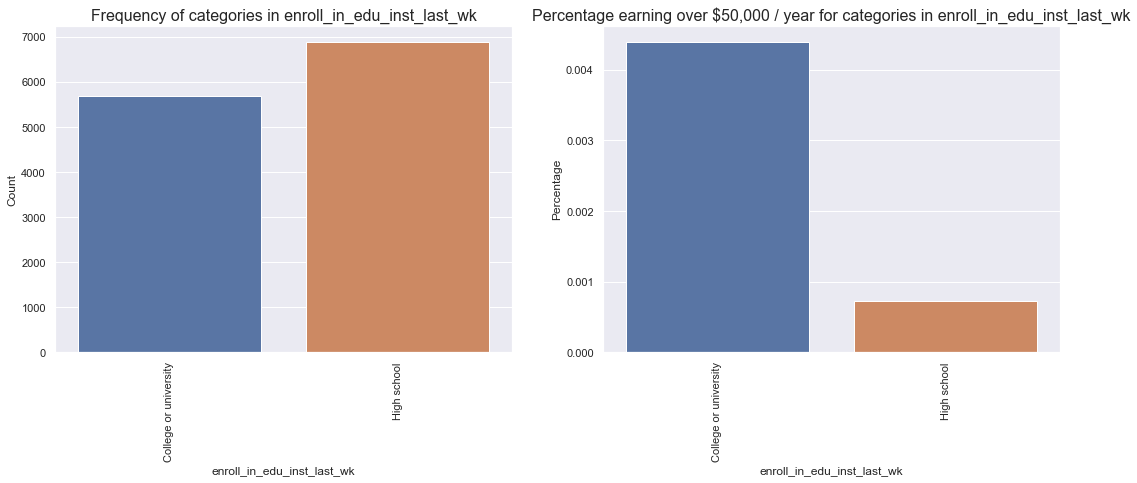

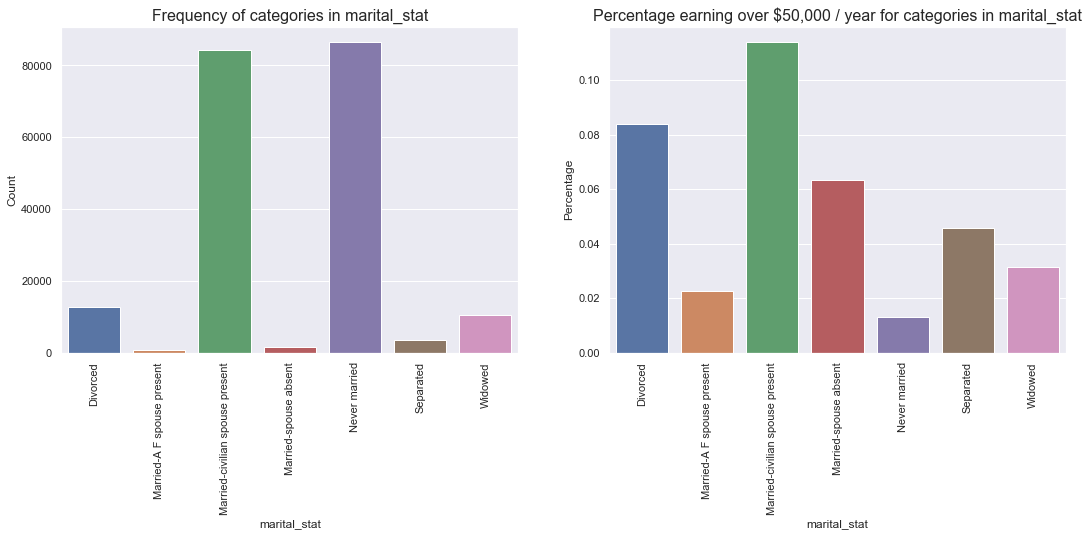

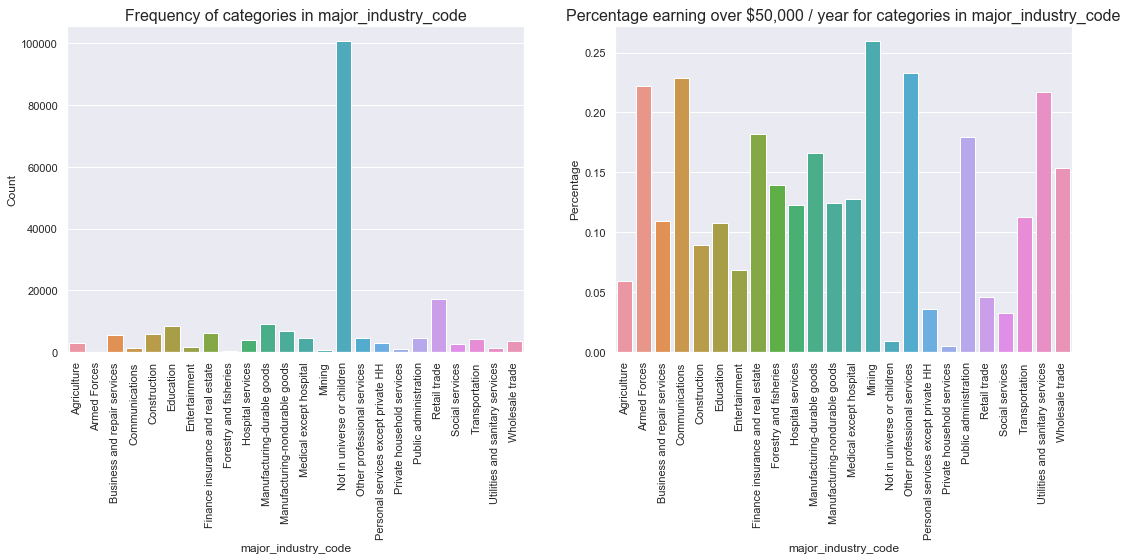

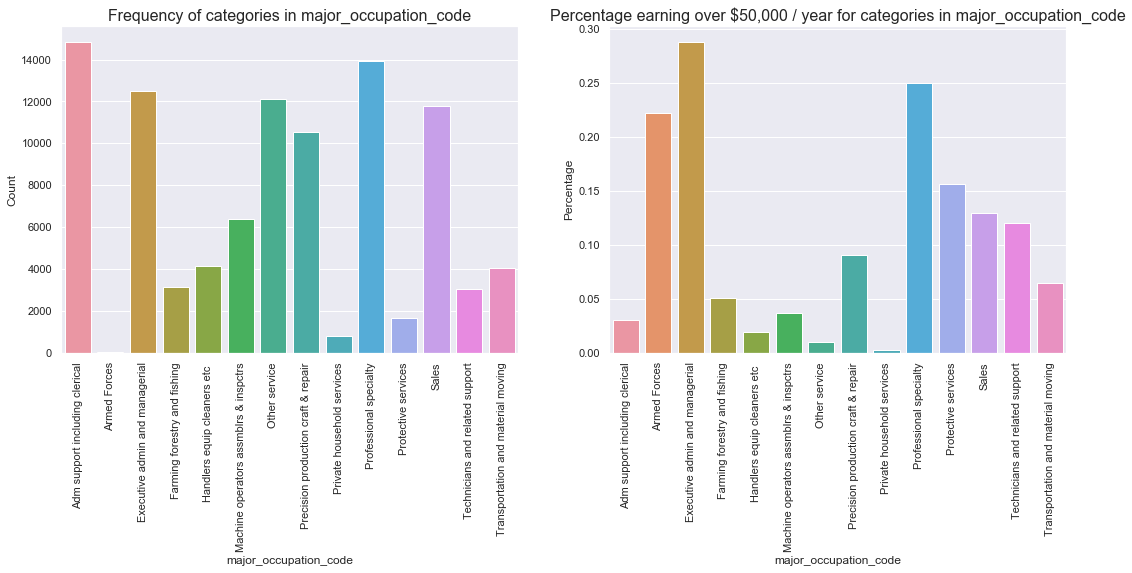

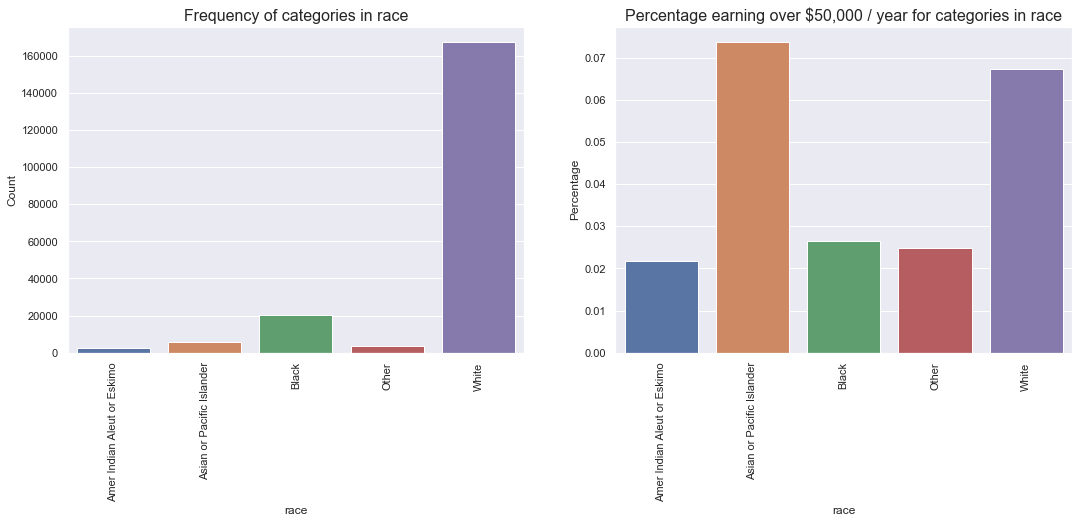

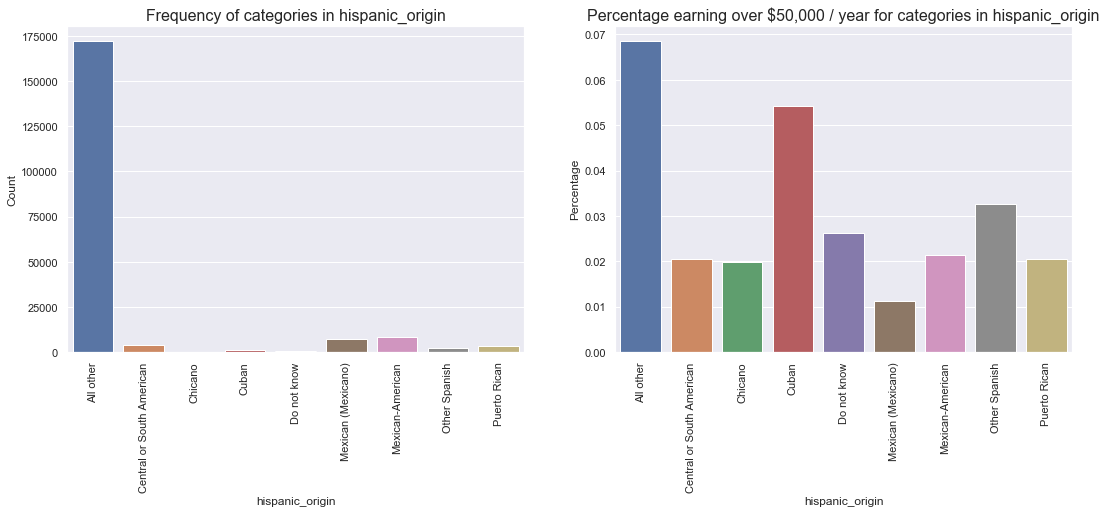

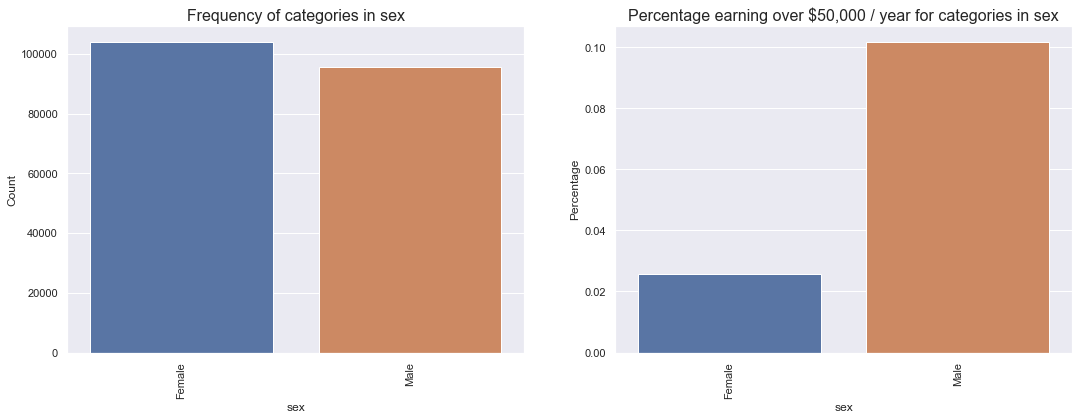

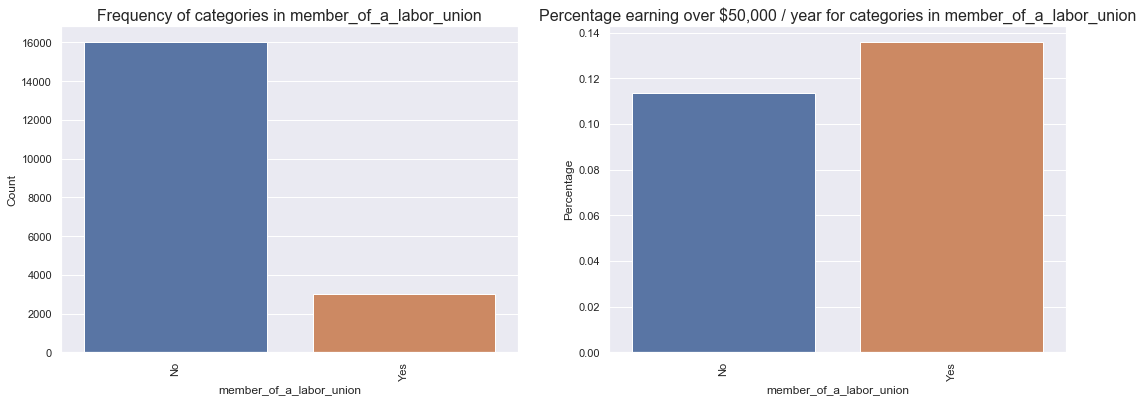

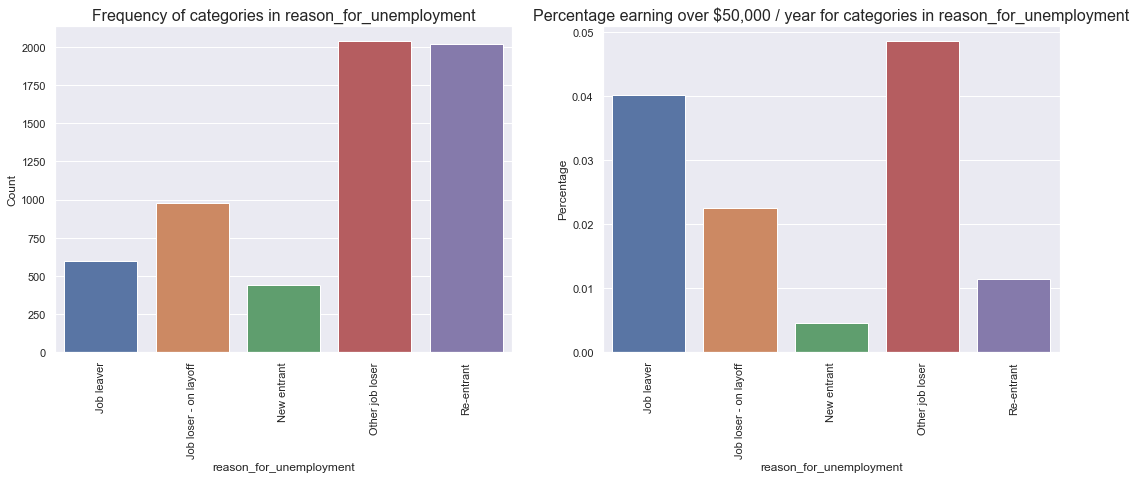

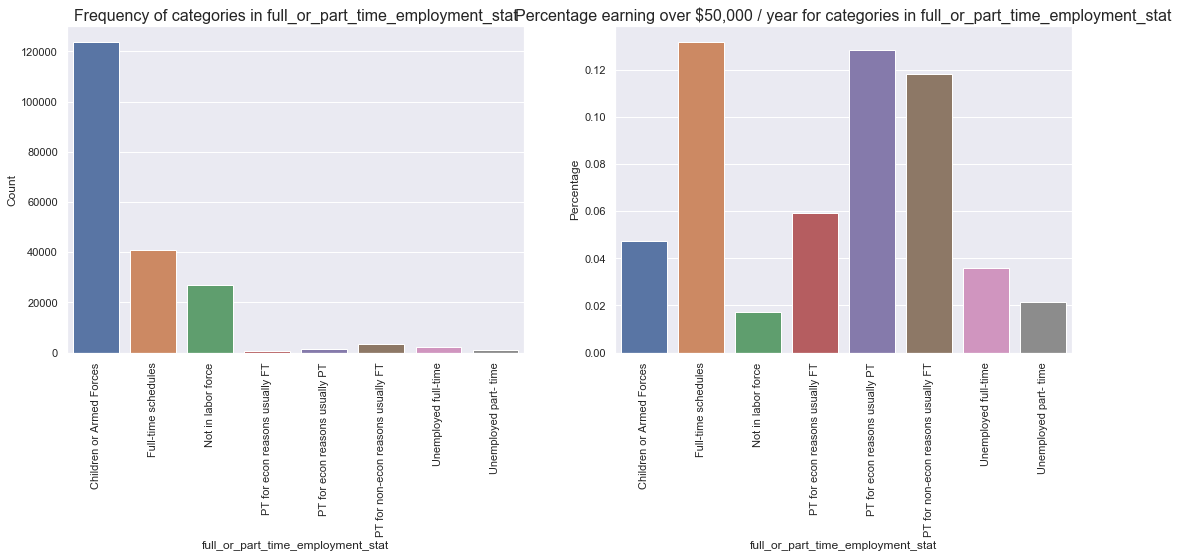

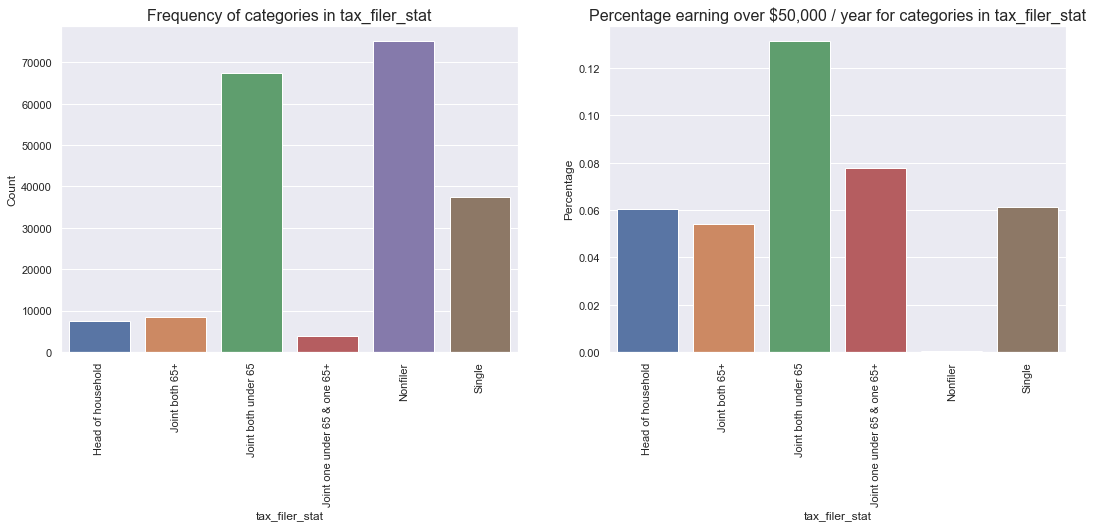

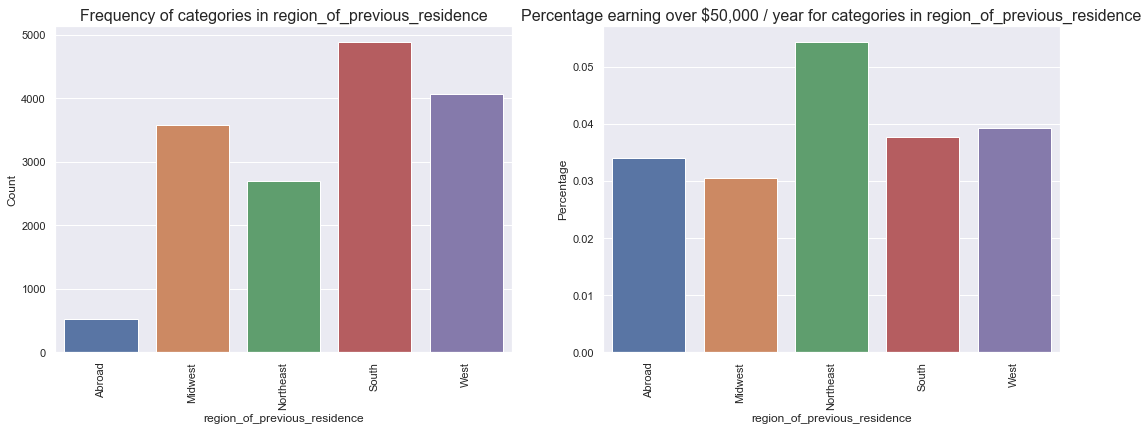

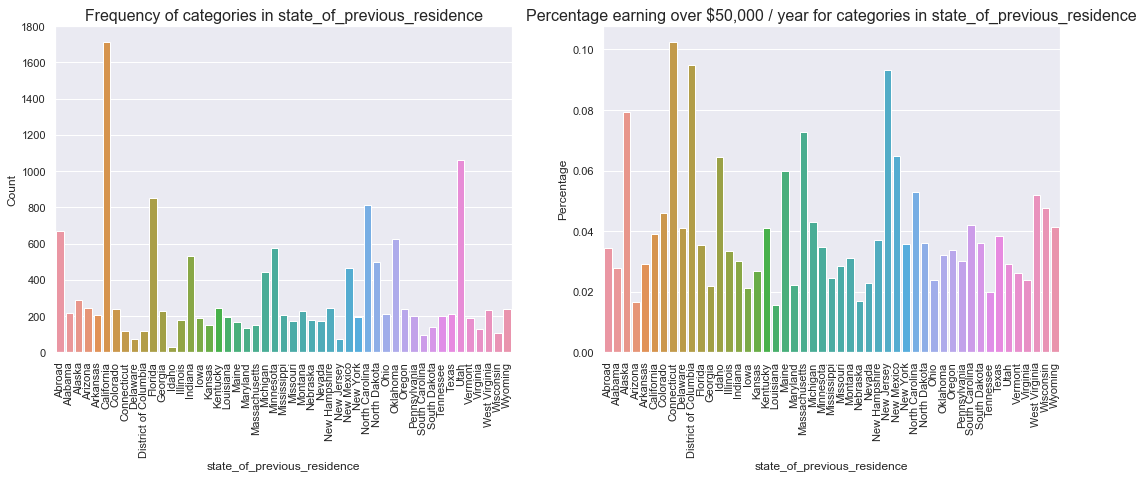

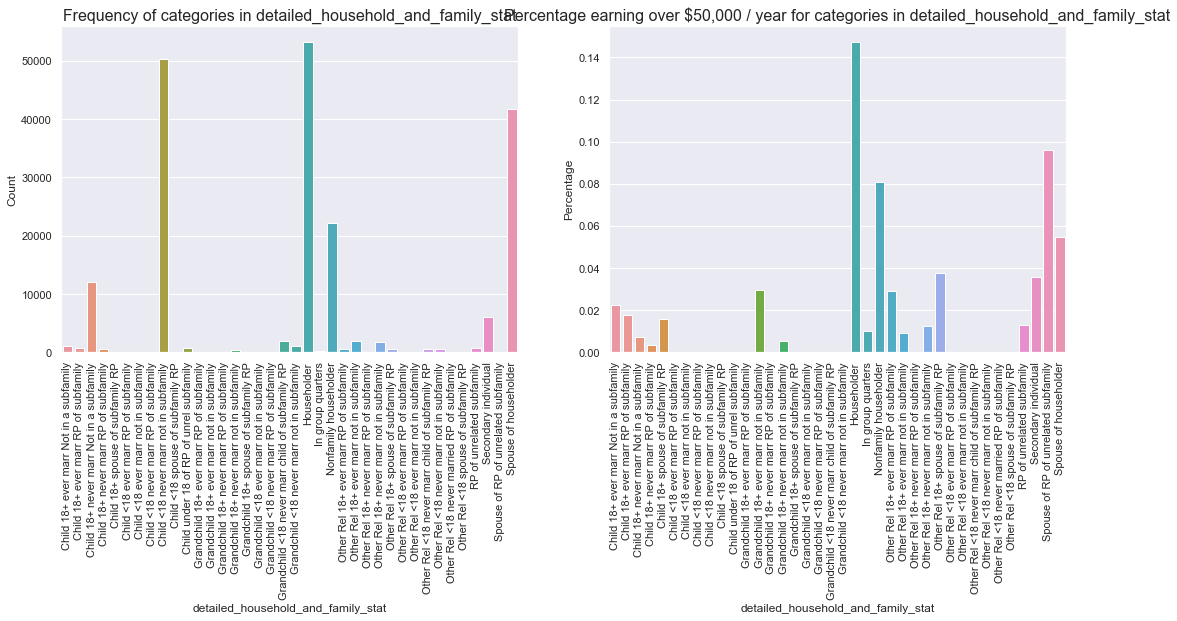

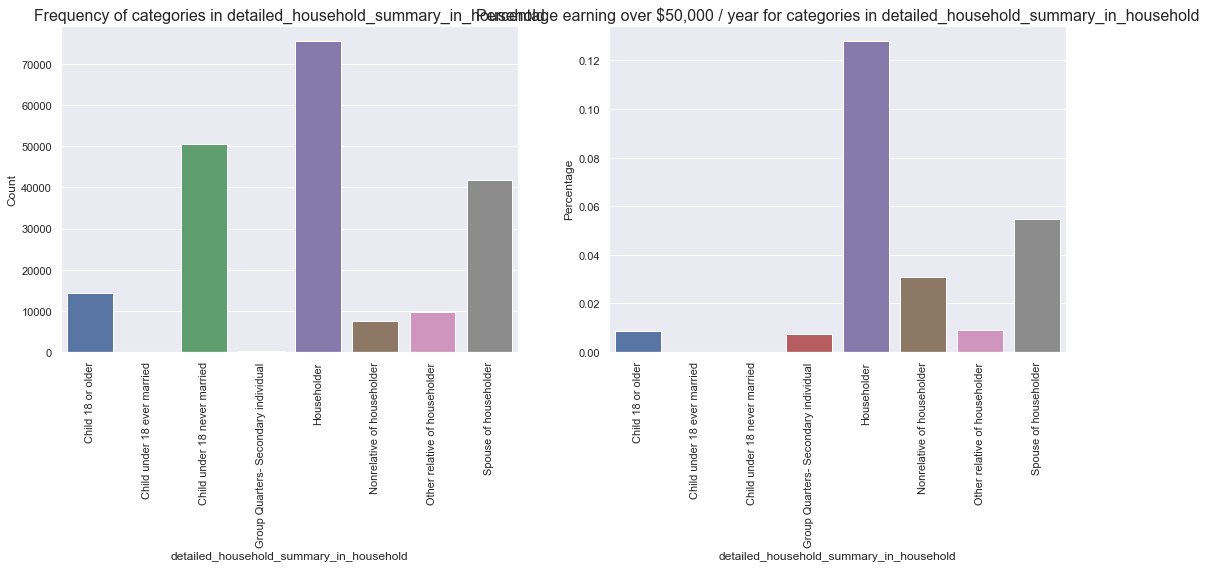

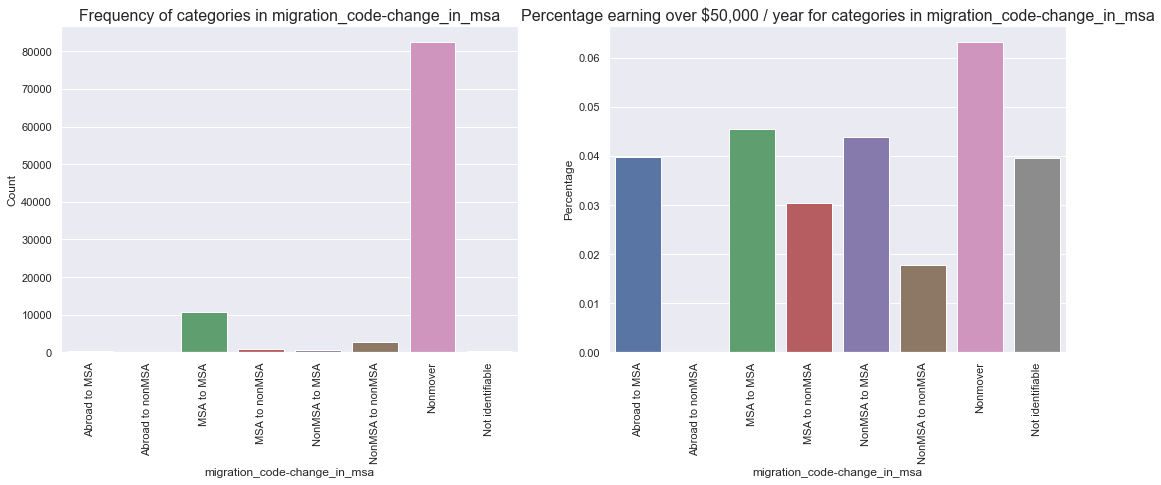

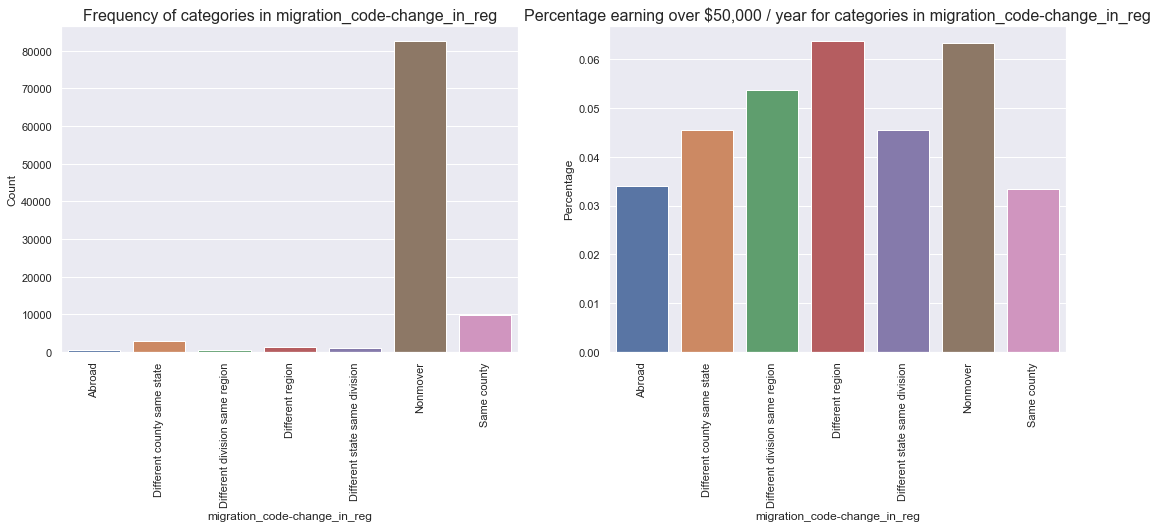

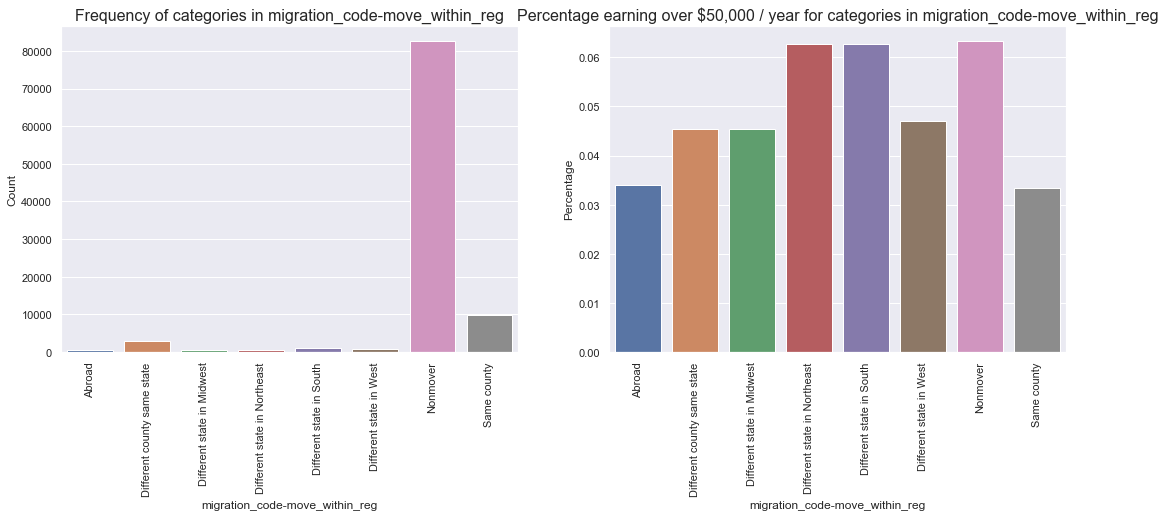

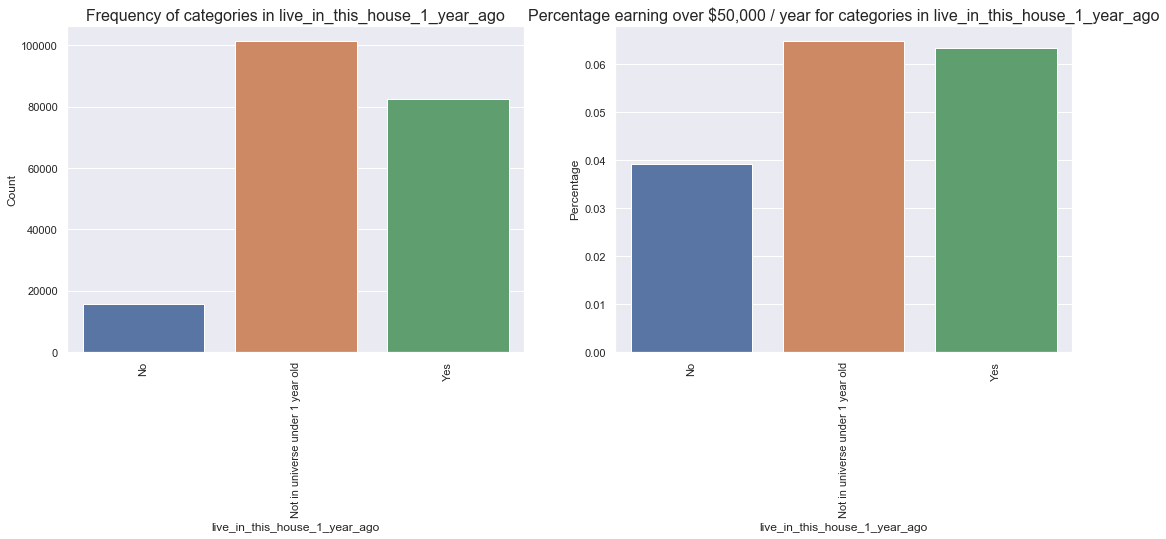

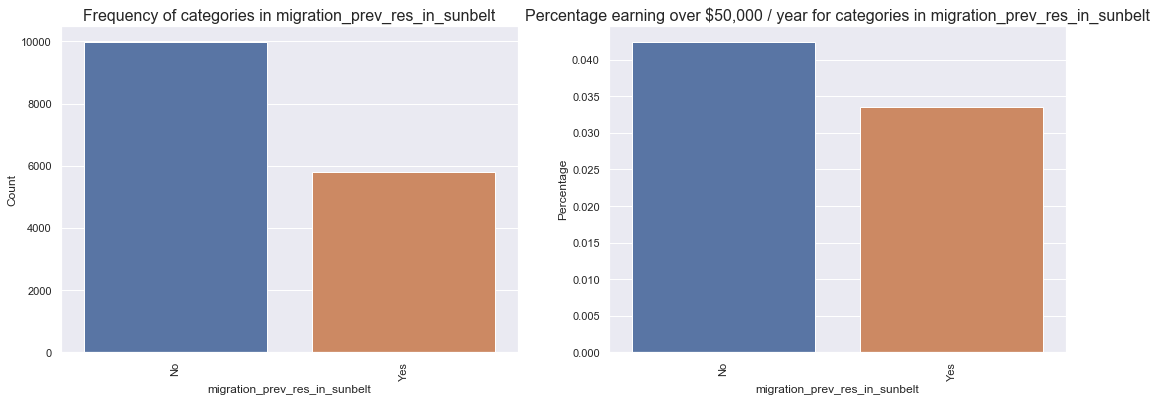

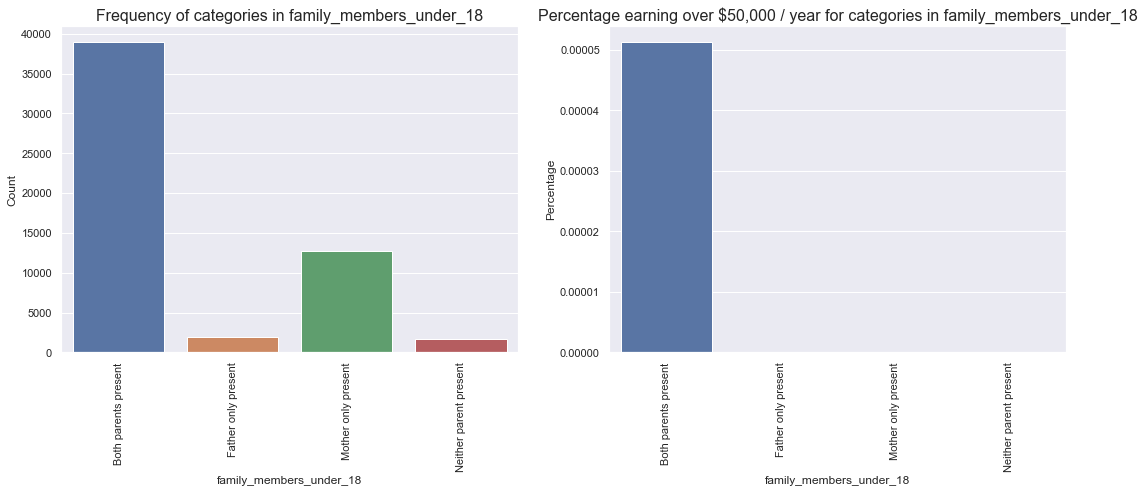

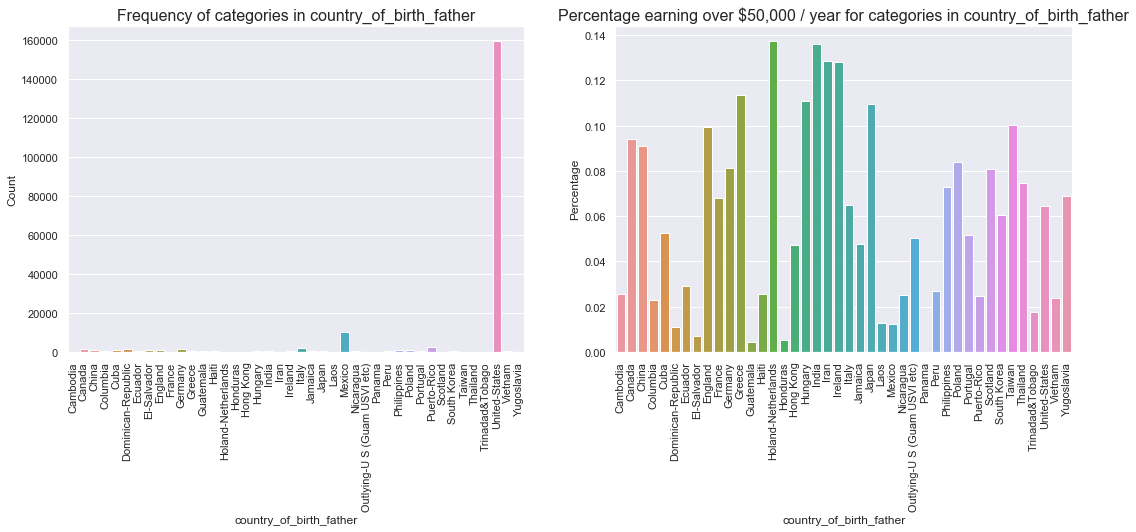

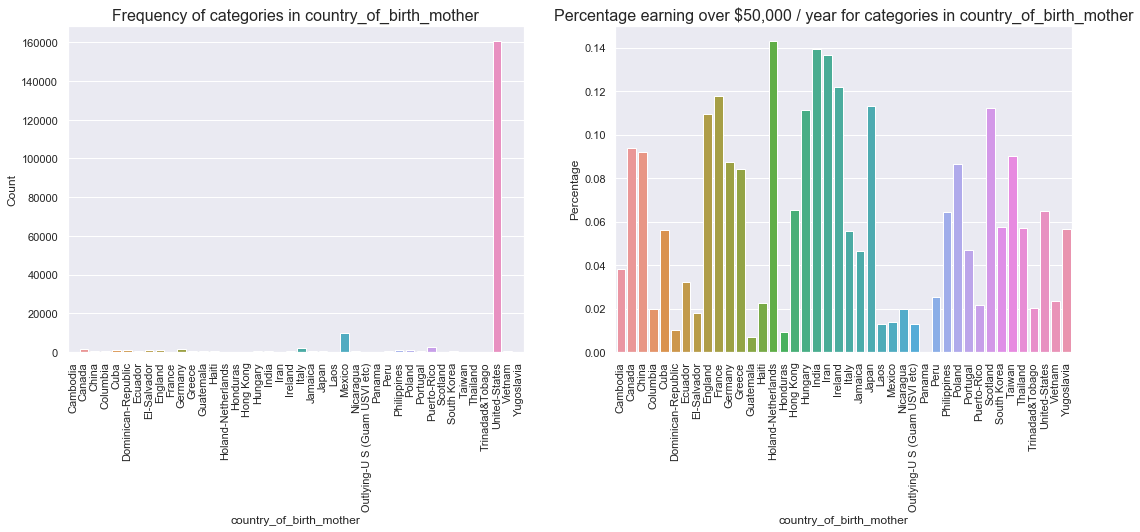

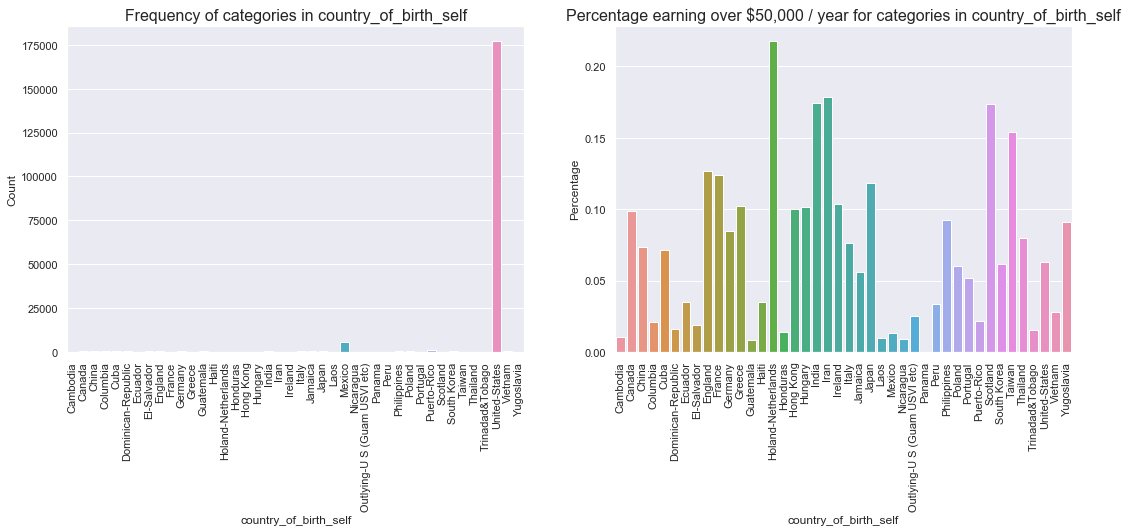

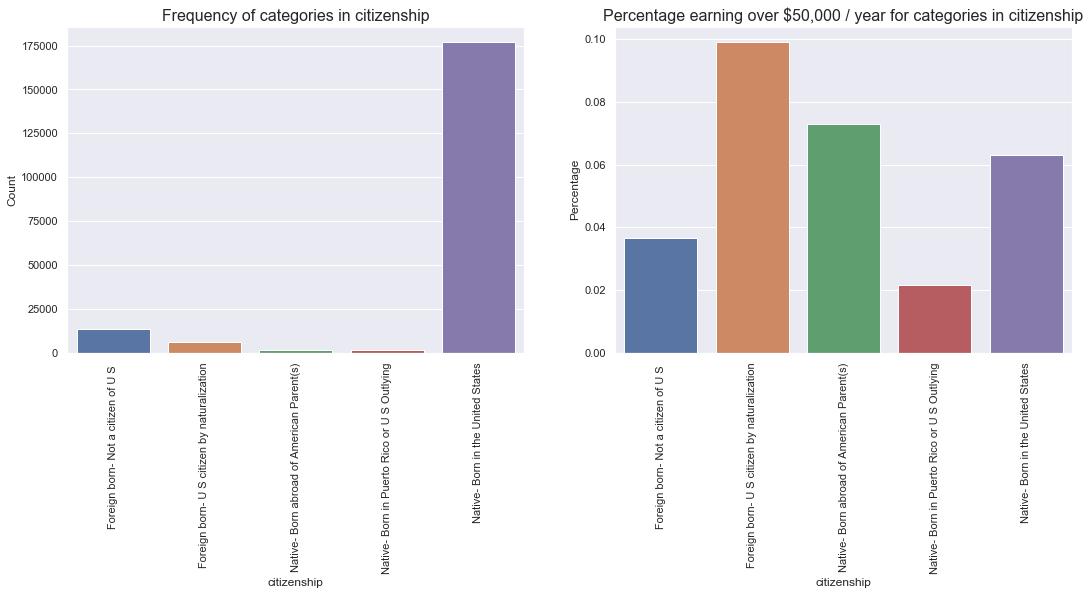

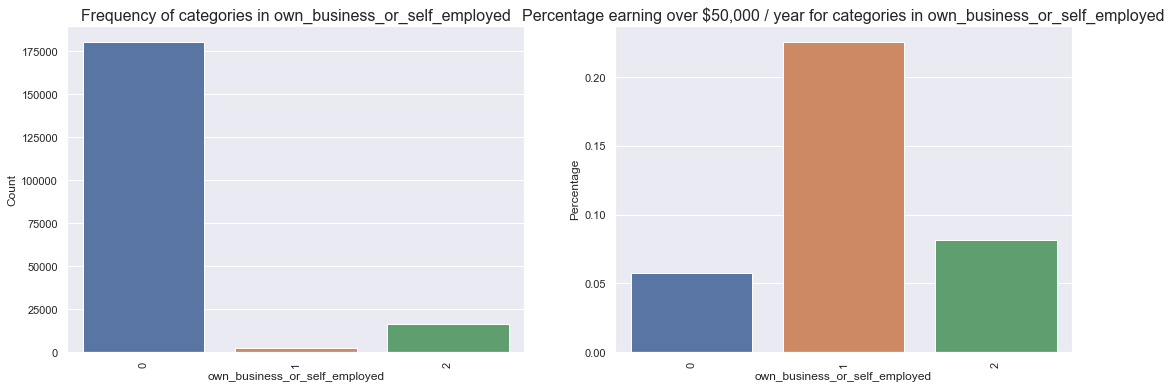

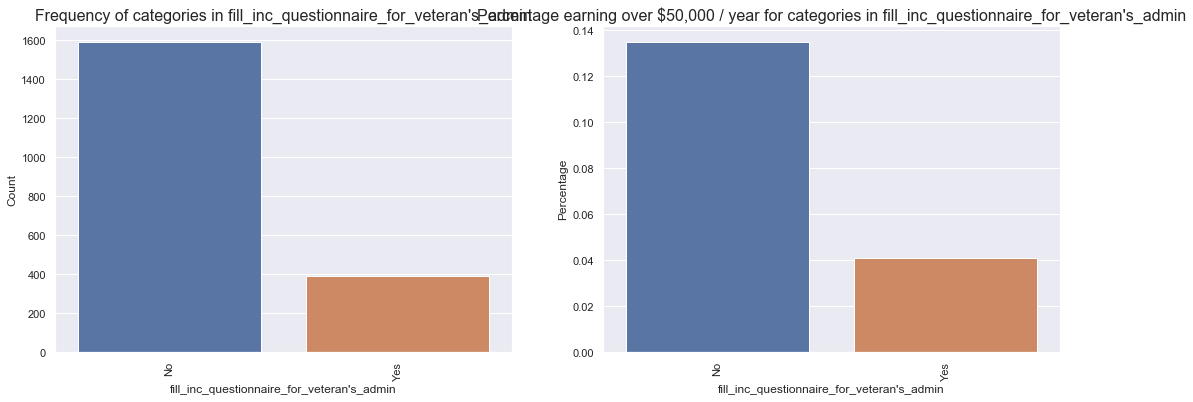

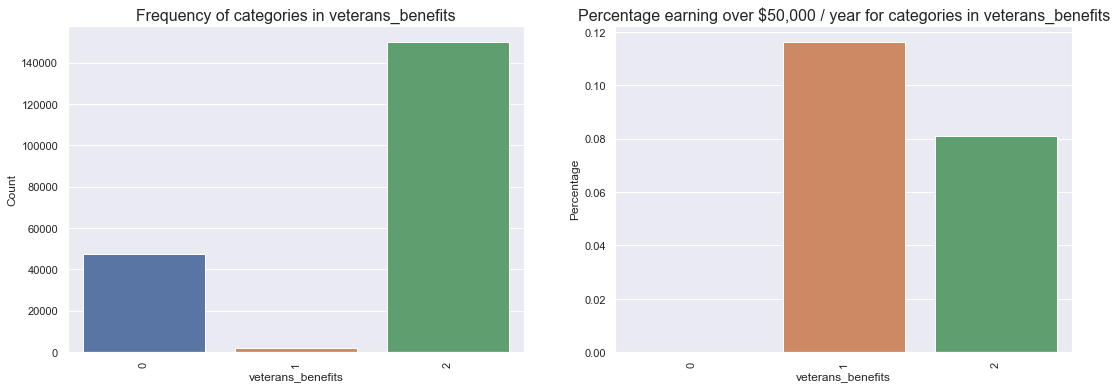

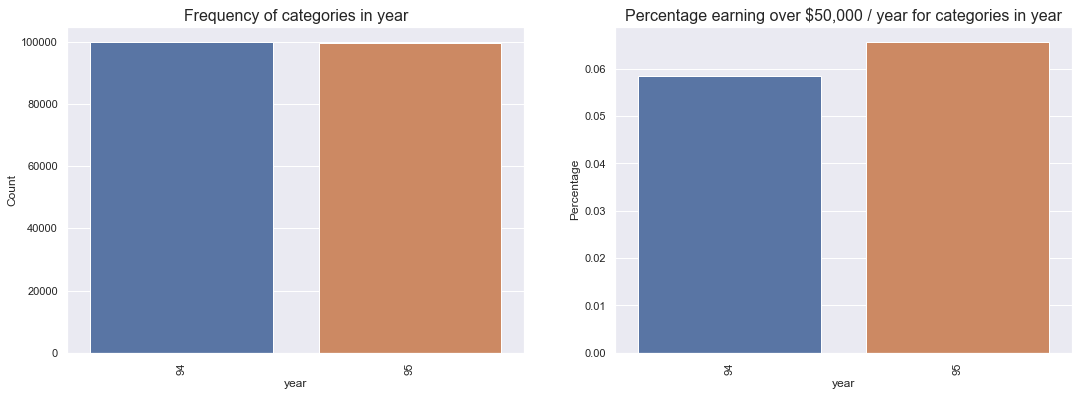

In [15]:
for i, col in enumerate(us_census_train.select_dtypes(['category'])):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    sns.countplot(x = col, data=us_census_train, ax=ax[0])
    ax[0].set_title('Frequency of categories in {}'.format(col), fontsize=16)
    ax[0].set_ylabel('Count')
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
    
    incomeByCol = us_census_train.groupby(col)['binaryIncome'].mean().reset_index()
    sns.barplot(x=col, y='binaryIncome', data=incomeByCol, ax=ax[1])
    ax[1].set_title('Percentage earning over $50,000 / year for categories in {}'.format(col), fontsize=16)
    ax[1].set_ylabel('Percentage')
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

Now plot continuous data. 

Left hand column shows both histogram and box plot for visual univariate analysis.

Right hand column shows distribution for both those earning above and below $50,000 / year.

For example we see that middle-aged people are most likely to earn above $50,000 / year.

(Note we are ignoring zeros for 'wage_per_hour', 'capital_gains', 'capital_losses','dividends_from_stocks' to get understanding of distribution of non-null data.)

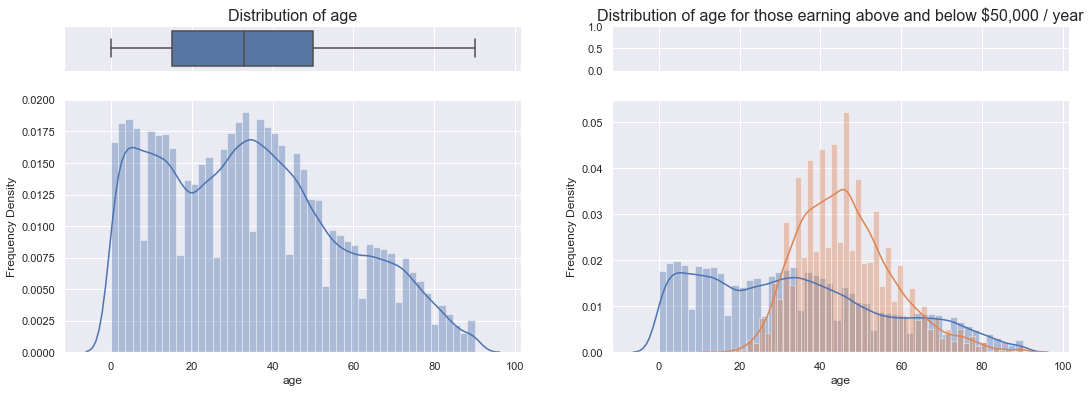

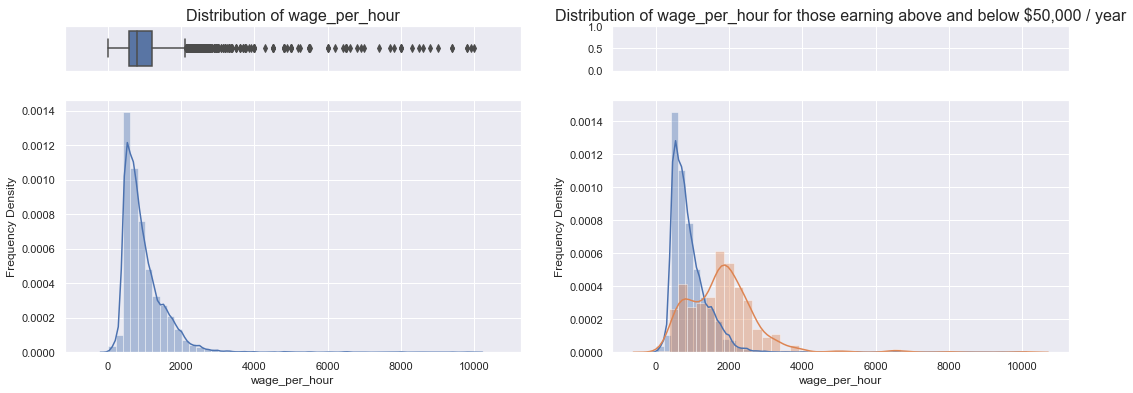

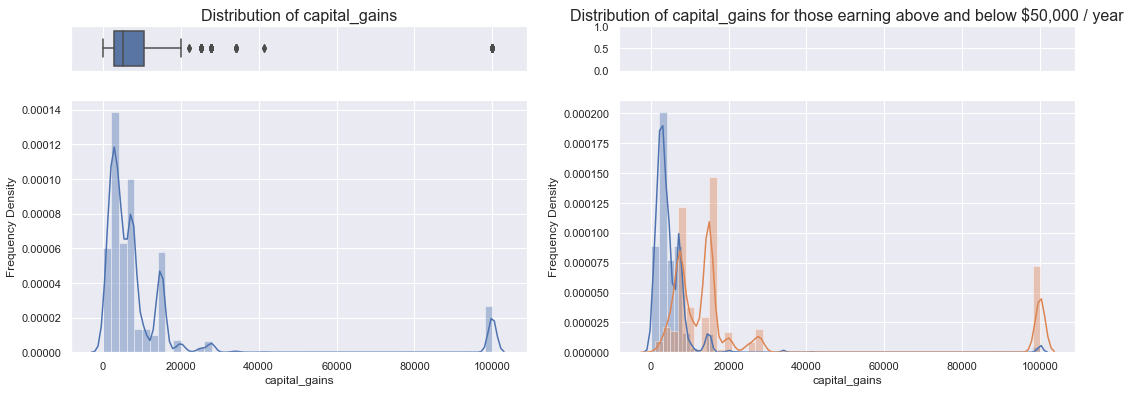

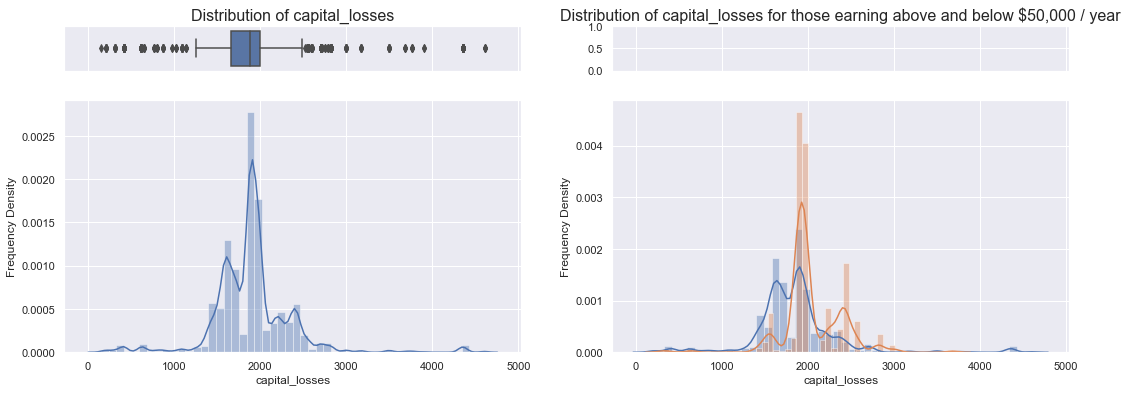

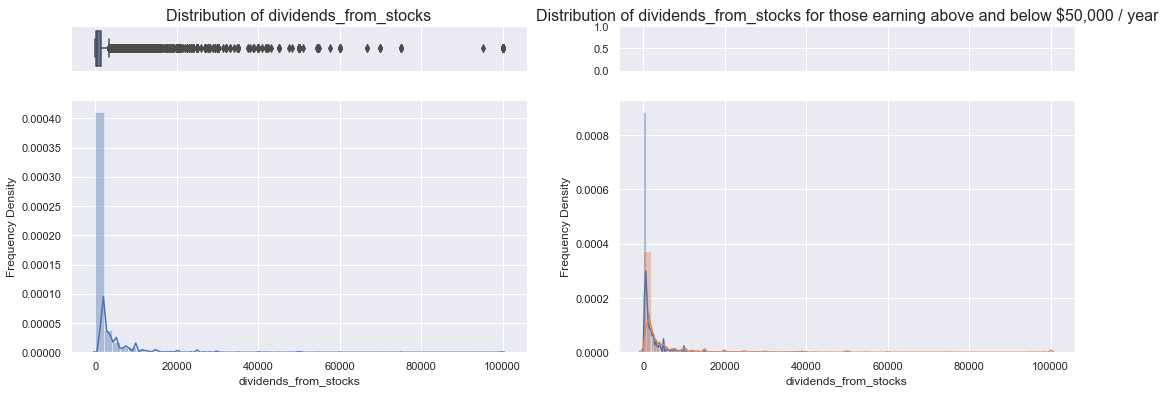

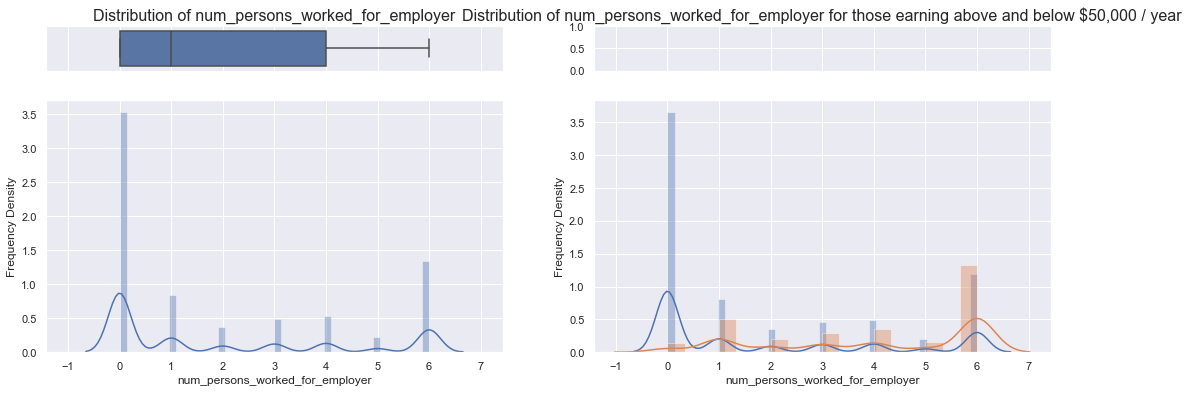

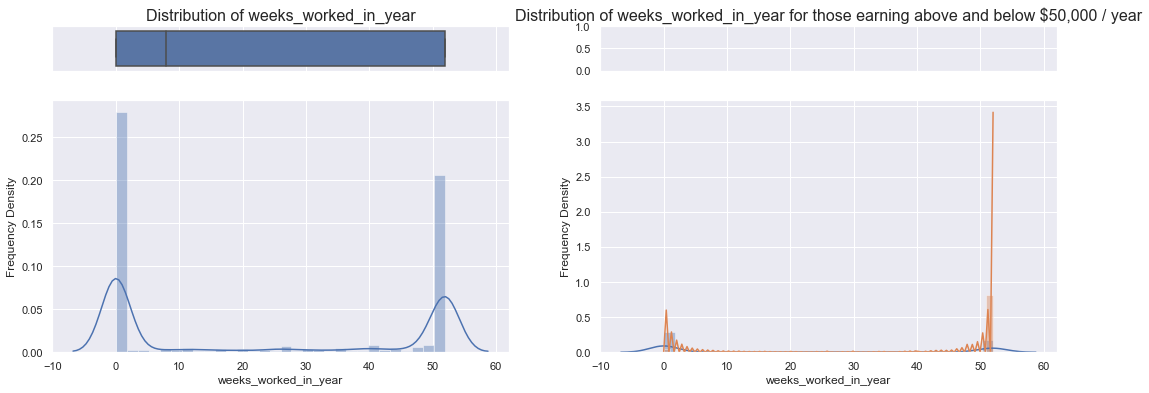

In [16]:
for i, col in enumerate(us_census_train.drop('binaryIncome',axis=1).select_dtypes(['int64'])):
    # Cut the window in 2 parts
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(18, 6), gridspec_kw={"height_ratios": (.15, .85)})

    # Add graph in each part
    if col in ['wage_per_hour', 'capital_gains', 'capital_losses','dividends_from_stocks']:
        sns.boxplot(us_census_train[us_census_train[col]>0][col], ax=ax[0,0])
        sns.distplot(us_census_train[us_census_train[col]>0][col], ax=ax[1,0])
        sns.distplot(us_census_train[(us_census_train[col]>0) & (us_census_train['binaryIncome'] == 0)][col], ax=ax[1,1])
        sns.distplot(us_census_train[(us_census_train[col]>0) & (us_census_train['binaryIncome'] == 1)][col], ax=ax[1,1])
    else:
        sns.boxplot(us_census_train[col], ax=ax[0,0])
        sns.distplot(us_census_train[col], ax=ax[1,0])
        sns.distplot(us_census_train[(us_census_train['binaryIncome'] == 0)][col], ax=ax[1,1])
        sns.distplot(us_census_train[(us_census_train['binaryIncome'] == 1)][col], ax=ax[1,1])

    ax[0,0].set_xlabel('')
    ax[1,0].set_ylabel('Frequency Density')
    ax[1,1].set_ylabel('Frequency Density')
    ax[0,0].set_title('Distribution of {}'.format(col), fontsize=16)
    ax[0,1].set_title('Distribution of {} for those earning above and below $50,000 / year'.format(col), fontsize=16)

## Processing Data for Modelling

In order to use this data in a machine learning model, first need to encode the categorical variables and scale numerical variables.

Here we use one-hot-encoding as our categorical variables do not have inherent order, and scale numerical variables by dividing by their variance (we choose not to account for variable mean here since we need to keep variables positive in order to compute chi2 for feature selection below).

In [17]:
X_train = pd.DataFrame()
X_test = pd.DataFrame()

assert sorted(us_census_train.columns) == sorted(us_census_test.columns)

for col in us_census_train:
    try:
        # Include binaryIncome column (y data) in processed data without modification
        if col == 'binaryIncome':
            X_train_col = pd.DataFrame(us_census_train[col], columns=[str(col)])
            X_test_col = pd.DataFrame(us_census_test[col], columns=[str(col)])
        # Scale numerical variables according to their variance and include in processed data:
        elif us_census_train[col].dtype.name == 'int64':
            scaler = StandardScaler(with_mean=False)
            X_train_col = pd.DataFrame(scaler.fit_transform(np.array(us_census_train[col]).reshape(-1,1)), columns=[str(col)+'_scaled'])
            X_test_col = pd.DataFrame(scaler.transform(np.array(us_census_test[col]).reshape(-1,1)), columns=[str(col)+'_scaled'])
        # One-hot-encode categorical variables
        elif us_census_train[col].dtype.name == 'category':
            X_train_col = pd.get_dummies(us_census_train[col], prefix=str(col))
            X_test_col = pd.get_dummies(us_census_test[col], prefix=str(col))
        else:
            print('Column {} not of appropriate type'.format(col))
        # Ensure both training and test data have columns for all possible encoded variables to keep them the same size
        if sorted(X_train_col.columns) != sorted(X_test_col.columns):
            for newTrainCol in X_train_col:
                if newTrainCol not in X_test_col.columns:
                    X_test_col[newTrainCol] = 0
            for newTestCol in X_test_col:
                if newTestCol not in X_test_col.columns:
                    X_train_col[newTestCol] = 0
        # Combine processed columns into processed data
        X_train = pd.concat([X_train, X_train_col], axis=1)
        X_test = pd.concat([X_test, X_test_col], axis=1)
    except:
        print("Exception on column {}: {}".format(col, sys.exc_info()[0]))

Separate out y data into separate dataframe.

In [18]:
y_train = X_train['binaryIncome']
y_test = X_test['binaryIncome']

X_train.drop('binaryIncome', axis=1, inplace=True)
X_test.drop('binaryIncome', axis=1, inplace=True)

In [19]:
X_train.describe(include='all')

,age_scaled,class_of_worker_Federal government,class_of_worker_Local government,class_of_worker_Never worked,class_of_worker_Private,class_of_worker_Self-employed-incorporated,class_of_worker_Self-employed-not incorporated,class_of_worker_State government,class_of_worker_Without pay,detailed_industry_recode_0,detailed_industry_recode_1,detailed_industry_recode_2,detailed_industry_recode_3,detailed_industry_recode_4,detailed_industry_recode_5,detailed_industry_recode_6,detailed_industry_recode_7,detailed_industry_recode_8,detailed_industry_recode_9,detailed_industry_recode_10,detailed_industry_recode_11,detailed_industry_recode_12,detailed_industry_recode_13,detailed_industry_recode_14,detailed_industry_recode_15,...,country_of_birth_self_Puerto-Rico,country_of_birth_self_Scotland,country_of_birth_self_South Korea,country_of_birth_self_Taiwan,country_of_birth_self_Thailand,country_of_birth_self_Trinadad&Tobago,country_of_birth_self_United-States,country_of_birth_self_Vietnam,country_of_birth_self_Yugoslavia,citizenship_Foreign born- Not a citizen of U S,citizenship_Foreign born- U S citizen by naturalization,citizenship_Native- Born abroad of American Parent(s),citizenship_Native- Born in Puerto Rico or U S Outlying,citizenship_Native- Born in the United States,own_business_or_self_employed_0,own_business_or_self_employed_1,own_business_or_self_employed_2,fill_inc_questionnaire_for_veteran's_admin_No,fill_inc_questionnaire_for_veteran's_admin_Yes,veterans_benefits_0,veterans_benefits_1,veterans_benefits_2,weeks_worked_in_year_scaled,year_94,year_95
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,...,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,1.546074,0.014660,0.039013,0.002200,0.361001,0.016364,0.042326,0.021186,0.000827,0.504624,0.004145,0.011006,0.002822,0.029992,0.002772,0.002777,0.002115,0.002757,0.004977,0.000020,0.008841,0.006766,0.004506,0.001479,0.002265,...,0.007017,0.000376,0.002361,0.001007,0.000566,0.000331,0.887061,0.001960,0.000331,0.067165,0.029345,0.008801,0.007613,0.887076,0.905520,0.013522,0.080958,0.007984,0.001960,0.237612,0.009944,0.752445,0.949346,0.500328,0.499672
std,1.000003,0.120188,0.193626,0.046855,0.480292,0.126871,0.201332,0.144003,0.028745,0.499980,0.064247,0.104332,0.053045,0.170564,0.052573,0.052621,0.045941,0.052431,0.070371,0.004477,0.093611,0.081978,0.066974,0.038423,0.047542,...,0.083472,0.019384,0.048529,0.031724,0.023791,0.018185,0.316519,0.044225,0.018185,0.250308,0.168772,0.093400,0.086921,0.316501,0.292497,0.115497,0.272771,0.088996,0.044225,0.425621,0.099221,0.431593,1.000003,0.500001,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.672319,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

## Feature Engineering

We now have 488 columns so need to do some feature engineering to reduce these to prevent overfitting and to ensure reasonable model run times.

First define feature selection function to reduce dataframe using given feature selection procedure.

In [20]:
def selectFeatures(feature_selection_model, X_train_data, X_test_data, y_train_data):
    selectedFeatures = feature_selection_model.fit_transform(X_train_data, y_train_data)
    
    mask = feature_selection_model.get_support() #list of booleans
    new_features = [] # The list of best features

    for bool, feature in zip(mask, X_train_data.columns):
        if bool:
            new_features.append(feature)
        
    X_train_data_reduced = pd.DataFrame(selectedFeatures, columns = new_features)
    X_test_data_reduced = X_test_data.loc[:,new_features]
    
    return X_train_data_reduced, X_test_data_reduced

Define some feature selection models and apply these to reduce the dataframe to a reasonable number of features.

To determine optimum number of features, recursive feature engineering could be used in combination with cross-validation to minimise number of features for maximum cross-validation score. However, currently have so many features (many of which are likely redundant one-hot-encoded features) that we first need to reduce the number of features significantly by other (univariate) means.

Here we try two methods:

1) SelectPercentile: Selecting top x percentile of features accoring to chi2 relationship with y. The issue here is that many redundant co-correlated features may be selected.

2) VarianceThreshold: Dropping all features which have a variance less than x. The issue here is that some informative features with low variance may be dropped.

In [21]:
sp5 = SelectPercentile(score_func = chi2, percentile=5)
sp10 = SelectPercentile(score_func = chi2, percentile=10)
sp20 = SelectPercentile(score_func = chi2, percentile=20)

VT70 = VarianceThreshold(threshold=(0.8 * (1 - 0.8)))
VT80 = VarianceThreshold(threshold=(0.8 * (1 - 0.8)))
VT90 = VarianceThreshold(threshold=(0.9 * (1 - 0.9)))

X_train_reduced_sp5, X_test_reduced_sp5 = selectFeatures(sp5, X_train, X_test, y_train)
X_train_reduced_sp10, X_test_reduced_sp10 = selectFeatures(sp10, X_train, X_test, y_train)
X_train_reduced_sp20, X_test_reduced_sp20 = selectFeatures(sp20, X_train, X_test, y_train)

X_train_reduced_VT70, X_test_reduced_VT70 = selectFeatures(VT70, X_train, X_test, y_train)
X_train_reduced_VT80, X_test_reduced_VT80 = selectFeatures(VT80, X_train, X_test, y_train)
X_train_reduced_VT90, X_test_reduced_VT90 = selectFeatures(VT90, X_train, X_test, y_train)

Look at example of reduced data:

In [22]:
X_train_reduced_sp10.describe()

,age_scaled,class_of_worker_Federal government,class_of_worker_Private,class_of_worker_Self-employed-incorporated,detailed_industry_recode_0,detailed_industry_recode_45,detailed_occupation_recode_0,detailed_occupation_recode_2,detailed_occupation_recode_3,detailed_occupation_recode_4,detailed_occupation_recode_5,detailed_occupation_recode_7,detailed_occupation_recode_11,detailed_occupation_recode_17,education_Bachelors degree(BA AB BS),education_Children,education_Doctorate degree(PhD EdD),education_Masters degree(MA MS MEng MEd MSW MBA),education_Prof school degree (MD DDS DVM LLB JD),marital_stat_Married-civilian spouse present,marital_stat_Never married,major_industry_code_Finance insurance and real estate,major_industry_code_Manufacturing-durable goods,major_industry_code_Not in universe or children,major_industry_code_Other professional services,major_industry_code_Public administration,major_occupation_code_Executive admin and managerial,major_occupation_code_Professional specialty,major_occupation_code_Sales,sex_Female,sex_Male,full_or_part_time_employment_stat_Full-time schedules,full_or_part_time_employment_stat_Not in labor force,capital_gains_scaled,capital_losses_scaled,dividends_from_stocks_scaled,tax_filer_stat_Joint both under 65,tax_filer_stat_Nonfiler,detailed_household_and_family_stat_Child <18 never marr not in subfamily,detailed_household_and_family_stat_Householder,detailed_household_summary_in_household_Child under 18 never married,detailed_household_summary_in_household_Householder,num_persons_worked_for_employer_scaled,family_members_under_18_Both parents present,family_members_under_18_Mother only present,own_business_or_self_employed_1,veterans_benefits_0,veterans_benefits_2,weeks_worked_in_year_scaled
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,1.546074,0.014660,0.361001,0.016364,0.504624,0.022464,0.504624,0.043885,0.016013,0.006836,0.004285,0.003664,0.003193,0.008876,0.099562,0.237677,0.00633,0.032783,0.008986,0.422117,0.433459,0.030798,0.045183,0.504624,0.022464,0.023105,0.062624,0.069867,0.059056,0.521163,0.478837,0.204167,0.13436,0.092542,0.137236,0.099553,0.337720,0.376368,0.252232,0.266877,0.252733,0.378277,0.827096,0.195381,0.064013,0.013522,0.237612,0.752445,0.949346
std,1.000003,0.120188,0.480292,0.126871,0.499980,0.148186,0.499980,0.204839,0.125526,0.082399,0.065321,0.060418,0.056413,0.093795,0.299416,0.425661,0.07931,0.178069,0.094370,0.493898,0.495554,0.172772,0.207705,0.499980,0.148186,0.150238,0.242287,0.254923,0.235730,0.499553,0.499553,0.403093,0.34104,1.000003,1.000003,1.000003,0.472934,0.484475,0.434295,0.442328,0.434580,0.484958,1.000003,0.396495,0.244776,0.115497,0.425621,0.431593,1.000003
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.672319,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

Features selected seem reasonable from univariate analysis above.

Note:
    
Attempted to use recursive feature engineering below to determine optimum number of features but was too slow to run even for reduced feature sets from univariate feature selection. Instead determine optimum number of features more approximately as below.

In [23]:
# # Create the RFE object and compute a cross-validated score.
# svc = SVC(kernel="linear")
# # The "accuracy" scoring is proportional to the number of correct
# # classifications
# rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
#               scoring='accuracy')
# rfecv.fit(X_train_reduced, y_train)

# print("Optimal number of features : %d" % rfecv.n_features_)

# # Plot number of features VS. cross-validation scores
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
# plt.show()

Now run simple logisitic regression model on each set of reduced features to determine optimum.

In [24]:
X_train_reduced = {'X_train_reduced_sp5': X_train_reduced_sp5,
                   'X_train_reduced_sp10': X_train_reduced_sp10,
                   'X_train_reduced_sp20': X_train_reduced_sp20,
                   'X_train_reduced_VT70': X_train_reduced_VT70, 
                   'X_train_reduced_VT80': X_train_reduced_VT80,
                   'X_train_reduced_VT90': X_train_reduced_VT90,}

for name, data in X_train_reduced.items():
    testModel = LogisticRegression()
    testModel.fit(data, y_train)
    CV_accuracy = np.mean(cross_val_score(testModel, data, y_train, cv=5))
    CV_F1 = np.mean(cross_val_score(testModel, data, y_train, cv=5, scoring = 'f1_macro'))
    print("Model using {} features accuracy: {}, F1 score: {}".format(name, CV_accuracy, CV_F1))
    print('\n')

Model using X_train_reduced_sp5 features accuracy: 0.9501009944101296, F1 score: 0.7112537762317033


Model using X_train_reduced_sp10 features accuracy: 0.9520506389755757, F1 score: 0.7329080375720296


Model using X_train_reduced_sp20 features accuracy: 0.9522761758787468, F1 score: 0.7361975852179281


Model using X_train_reduced_VT70 features accuracy: 0.9464272322603817, F1 score: 0.6495929803187471


Model using X_train_reduced_VT80 features accuracy: 0.9464272322603817, F1 score: 0.6495929803187471


Model using X_train_reduced_VT90 features accuracy: 0.9469534833599134, F1 score: 0.658840198687817




We see that selecting features according to their chi2 with y gives much better results than selecting features according to their variance. 

We also see that using the top 10% of features gives a higher cross-validated F1 score than using 5% and gives a similar score to using 20% (with better run time and less risk of overfitting) so for rest of exercise use sp10 reduced feature set.

With more time available could further optimise this feature engineering.

## Fitting Models

Now run a selection of ML models to see which gives the highest accuracy. Here use logisitic regression, a decision tree, random forest, and Gaussian naive Bayes, all with default hyperparameters to begin with.

Also tried using a support vector classifier and neural network but run time (using default hyperparameters) was too slow for selected features. With more time available could try using these models with further reduced feature sets.

In [25]:
logReg = LogisticRegression()
DT = DecisionTreeClassifier()
RF = RandomForestClassifier()
GNB = GaussianNB()
#SVC = SVC()
#MLP = MLPClassifier()

models = {'LogisticRegression':logReg,
          'DecisionTreeClassifier':DT,
          'RandomForestClassifier':RF, 
          'GaussianNB':GNB
          #'SupportVectorClassifier':SVC, 
          #'MLPClassifier':MLP
         }

Fit and cross-validate models:

In [26]:
model_scores = []

for modelName, model in models.items():
    model.fit(X_train_reduced_sp10, y_train)
    CV_accuracy = np.mean(cross_val_score(model, X_train_reduced_sp10, y_train, cv=3))
    CV_F1 = np.mean(cross_val_score(model, X_train_reduced_sp10, y_train, cv=3, scoring = 'f1_macro'))
    model_scores.append([modelName, CV_accuracy, CV_F1])
    print(model)
    print("{} model accuracy: {}, F1 score: {}".format(modelName, CV_accuracy, CV_F1))
    print('\n')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
LogisticRegression model accuracy: 0.952040614500374, F1 score: 0.7329453494950968


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
DecisionTreeClassifier model accuracy: 0.9347594047758817, F1 score: 0.7201501892419966


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
 

In [27]:
model_scores_df = pd.DataFrame(model_scores, columns = ['Model','Accuracy','F1_Score']).sort_values('F1_Score', ascending = False)
model_scores_df

,Model,Accuracy,F1_Score
2,RandomForestClassifier,0.948753,0.735625
0,LogisticRegression,0.952041,0.732945
1,DecisionTreeClassifier,0.934759,0.720150
3,GaussianNB,0.573383,0.463413


We see that the Random Forest classifier has the highest accuracy and F1 score from the selected models using the default hyperparameters. With more time would really need to optimise the hyperparameters for each model for a fair comparison, but given time available choose Random Forest classifier here.

## Testing Model

Now calculate classification accuracy on test data:

In [28]:
y_pred_RF = RF.predict(X_test_reduced_sp10)
print(accuracy_score(y_test, y_pred_RF))

0.9504420520839598


So we have achieved 95.0% classification accuracy on the test data. However, since this is a very imbalanced dataset (the vast majority of people earn less than 50,000 / year), note that if our classifier always predicted that someone earned less than $50 000 / year, it would still have a 93.8\% accuracy!

In [29]:
# Percentage accuracy achieved on test data if always predict 0:
(len(y_test)-sum(y_test))/len(y_test)

0.937992421964275

Instead need to look at confusion matrix to determine quality of model:

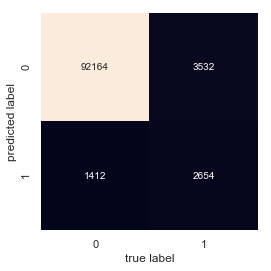

In [30]:
# Create confusion matrix
mat = confusion_matrix(y_test, y_pred_RF)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

We see that the classification is reasonable, but there is still a bias towards classifying people as earning less than $50 000 / year due to the imbalance in the data. Can score model according to F1 score, precision and recall:

In [31]:
print('F1 Score: {:.2f}, Precision: {:.2f}, Recall: {:.2f}'.format(f1_score(y_test, y_pred_RF), precision_score(y_test, y_pred_RF), recall_score(y_test, y_pred_RF)))

F1 Score: 0.52, Precision: 0.65, Recall: 0.43


Since this F1 score is significantly lower than the cross-validated F1 score, there is evidence that we are overfitting. 

With more time available, this could be reduced by optimising the hyperparameters in the models. For example, stronger regularisation (L1 or L2) could be included for the logistic regression model, or the maximum depth of the trees in the random forest model could be fixed to a finite value. Additional feature engineering could also be carried out to further reduce the number of features included in the model. One option might be to combine variables manually in a sensible way, for example defining a feature 'eductation to degree level or above' or 'capital gains - capital losses' to reduce features but preserve information. Alternatively, measures could be taken to reduce the imbalance in the training data such as bootstrapping.

Overall this model performs reasonably, so now get some insight on the profiles of the people that make more than $50,000 / year.

## Model Interpretation

Random forest feature importances for top 10 features:

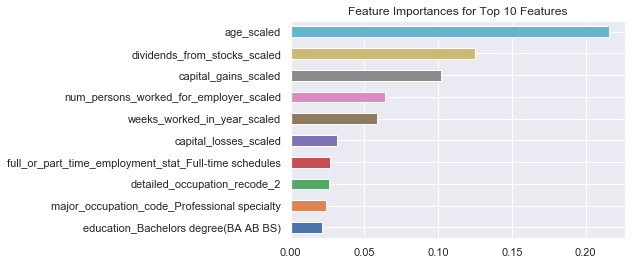

In [32]:
feature_importances = pd.Series(RF.feature_importances_, index = X_test_reduced_sp10.columns).nlargest(10).sort_values(ascending=True)
feature_importances.plot(kind='barh', title='Feature Importances for Top 10 Features')

We see that age is the most discriminitive factor available in determining a person's income bracket. As we saw in the visualisation above, those in middle age (generally between 25 and 70) are by far most likely to earn above $50 000 / year.

After age, factors associated with financial trading such as dividends and capital gains are the next most important factors. People who are involved in financial trading and so receive dividends/capital gains are more likely to earn above $50 000 / year.

Finally, factors related to employment such as amount of time worked, size of employer, education and occupation type also make it into the top 10 most import features. As you might expect, those working full time with a degree (bachelors/masters level), particularly in executive admin/managerial roles are more likely to earn above $50 000 / year.

## Summary

We have successfuly built a model to predict if a person earns above $50 000 / year from census data with 95.0\% accuracy (F1 score of 0.52) which has given us a clear insight on the profile's of people earning above this threshold.

We have seen that those in middle age, associated with financial trading, working full-time, particularly in executive admin/managerial roles with a degree are more likely to earn more than $50 000 / year.

With more time available this model could be improved by carrying out further feature engineering and optimising hyperparameters to prevent the current overfitting of the model and improve the F1 score.